### This is a new version of MLEAP scripts, started in late Aug 2022.
It will combine IProject_MLEAP_ANN and IP_MLEAP script, while improving them.

#### Outline

1. Load libraries and data.
2. pEDA. Look at feature distribution, fix them if they do not look right.
3. Train-test split. Most likely couple years into test set. 2015-2018?. Impute missing values.
4. Transform numerical features, add ohe for inds.
5. Fit classic models: ols as a baseline, then xgb.
6. Fir DL.


Notes:
ideally, I want to use time-based cross-validation.
since I have panel data, it is not a trivial task.
need to find some solution online.
e.g., https://towardsdatascience.com/time-based-cross-validation-d259b13d42b8.

for now, will try to do siple for loop.


In [299]:
# 0. Import libraries #

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, time, math, re, warnings, random, gc, dill, optuna, pickle
import statsmodels.api as sm
from random import sample

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNetCV
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.inspection import permutation_importance
from category_encoders import MEstimateEncoder
from xgboost import XGBRegressor

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

plt.style.use('seaborn-white')
warnings.simplefilter(action='ignore')
pd.set_option('display.max_columns', 110)
gc.enable()

In [300]:
### target encoding ###
# source: https://www.kaggle.com/code/ryanholbrook/feature-engineering-for-house-prices/notebook

class CrossFoldEncoder:
    def __init__(self, encoder, **kwargs):
        self.encoder_ = encoder
        self.kwargs_ = kwargs  # keyword arguments for the encoder
        self.cv_ = KFold(n_splits=4)

    # Fit an encoder on one split and transform the feature on the
    # other. Iterating over the splits in all folds gives a complete
    # transformation. We also now have one trained encoder on each
    # fold.
    def fit_transform(self, X, y, cols):
        self.fitted_encoders_ = []
        self.cols_ = cols
        X_encoded = []
        for idx_encode, idx_train in self.cv_.split(X):
            fitted_encoder = self.encoder_(cols=cols, **self.kwargs_)
            fitted_encoder.fit(
                X.iloc[idx_encode, :], y.iloc[idx_encode],
            )
            X_encoded.append(fitted_encoder.transform(X.iloc[idx_train, :])[cols])
            self.fitted_encoders_.append(fitted_encoder)
        X_encoded = pd.concat(X_encoded)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

    # To transform the test data, average the encodings learned from
    # each fold.
    def transform(self, X):
        from functools import reduce

        X_encoded_list = []
        for fitted_encoder in self.fitted_encoders_:
            X_encoded = fitted_encoder.transform(X)
            X_encoded_list.append(X_encoded[self.cols_])
        X_encoded = reduce(
            lambda x, y: x.add(y, fill_value=0), X_encoded_list
        ) / len(X_encoded_list)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

In [301]:
# Detect TPU, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [302]:
# 1. Import data #

# window: 3y seems good?

min_prd = 300
windows_width = 3*12

results = pd.DataFrame(columns = ['min_prd', 'xgbf', 'xgbgs', 'xgbo'])

time0 = time.time()
#df = pd.read_csv('../input/cpcrsp-46/IMLEAP_v4.csv')
with open('../input/kaggle-46pkl/IMLEAP_v4.pkl', 'rb') as pickled_one:
    df = pickle.load(pickled_one)
df = df[df.prd.isin(range(min_prd-1, min_prd+windows_width+2))]
display(df.shape, df.head(), df.year.describe(), df.count())

(89414, 46)

,PERMNO,prd,mom482,mom242,year,RET,ind,bm,op,gp,inv,mom11,mom122,amhd,ivol_capm,ivol_ff5,beta_bw,MAX,vol1m,vol6m,vol12m,BAspr,size,lbm,lop,lgp,linv,llme,l1amhd,l1MAX,l1BAspr,l3amhd,l3MAX,l3BAspr,l6amhd,l6MAX,l6BAspr,l12amhd,l12MAX,l12BAspr,l12mom122,l12ivol_capm,l12ivol_ff5,l12beta_bw,l12vol6m,l12vol12m
224,10006,299,-19.434584,-38.390360,1983,0.1605,25.0,0.467418,0.097309,0.220497,0.118136,-4.5159,-9.790204,1.628314,1.033030,0.727775,0.814121,1.4386,1.157497,1.825477,1.691859,NaN,5.560153,0.274945,0.118348,0.237469,0.091161,5.825327,1.626665,4.1337,NaN,1.715833,4.1367,NaN,1.781569,5.0932,NaN,1.422049,4.1337,NaN,-30.659974,0.986262,0.964204,0.843484,1.687154,1.437885
225,10006,300,-21.388149,-35.843377,1983,5.9567,25.0,0.467418,0.097309,0.220497,0.118136,0.1605,-7.157811,1.598340,1.063466,0.936522,0.799767,2.3259,1.152686,1.614224,1.667907,NaN,5.568027,0.274945,0.118348,0.237469,0.091161,5.740770,1.628314,1.4386,NaN,1.671621,4.0013,NaN,1.786906,4.5785,NaN,1.440860,1.4386,NaN,-30.101733,1.193522,1.015454,0.852702,1.554393,1.440870
226,10006,301,-13.964189,-34.528211,1983,-1.4988,25.0,0.467418,0.097309,0.220497,0.118136,5.9567,-12.456541,1.521537,1.313733,1.155573,0.808885,4.1307,1.433440,1.474423,1.647114,NaN,5.632566,0.274945,0.118348,0.237469,0.091161,5.811722,1.598340,2.3259,NaN,1.626665,4.1337,NaN,1.762098,3.9561,NaN,1.526839,2.3259,NaN,-29.730986,1.645750,1.498313,0.865615,1.602011,1.493237
227,10006,302,-17.681530,-29.776396,1983,2.7008,25.0,0.467418,0.097309,0.220497,0.118136,-1.4988,0.904921,1.485340,2.426025,2.027979,0.825450,4.3466,2.604619,1.663623,1.780087,NaN,5.621046,0.274945,0.118348,0.237469,0.091161,5.718464,1.521537,4.1307,NaN,1.628314,1.4386,NaN,1.715833,4.1367,NaN,1.559589,4.1307,NaN,-29.282674,0.983334,0.916348,0.864828,1.585183,1.486680
228,10006,303,-18.595559,-22.961625,1983,-2.1893,25.0,0.784207,0.088427,0.222761,-0.032575,2.7008,8.156360,1.298865,1.393089,1.343269,0.796333,3.7153,1.412173,1.616113,1.743533,NaN,5.654198,0.467418,0.097309,0.220497,0.118136,5.650019,1.485340,4.3466,NaN,1.598340,2.3259,NaN,1.671621,4.0013,NaN,1.691079,4.3466,NaN,-28.654955,1.557424,1.486731,0.901204,1.618876,1.559004


count    89414.000000
mean      1984.326616
std          0.986718
min       1983.000000
25%       1984.000000
50%       1984.000000
75%       1985.000000
max       1986.000000
Name: year, dtype: float64

PERMNO          89414
prd             89414
mom482          77366
mom242          87910
year            89414
RET             89414
ind             89414
bm              89414
op              89414
gp              89414
inv             89384
mom11           89414
mom122          89414
amhd            67483
ivol_capm       89406
ivol_ff5        89406
beta_bw         89414
MAX             89414
vol1m           89392
vol6m           89332
vol12m          89193
BAspr           15086
size            89414
lbm             89414
lop             89414
lgp             89414
linv            89414
llme            89414
l1amhd          66888
l1MAX           89409
l1BAspr         14548
l3amhd          65668
l3MAX           89393
l3BAspr         13462
l6amhd          63736
l6MAX           89361
l6BAspr         12365
l12amhd         59151
l12MAX          89409
l12BAspr         8683
l12mom122       88531
l12ivol_capm    89301
l12ivol_ff5     89301
l12beta_bw      89339
l12vol6m        89013
l12vol12m 

(89414, 46)
(89142, 46)


<AxesSubplot:>

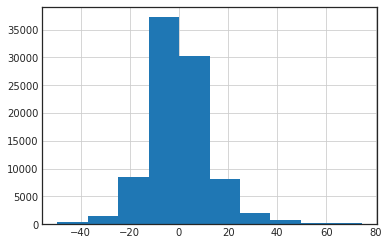

In [303]:
# 2. pEDA #

print(df.shape)
df = df[(df.RET>-50)&(df.RET<75)]
print(df.shape)
df.RET.hist()

In [304]:
meanret = df.groupby('prd').RET.mean().to_frame().reset_index().rename(columns={'RET':'mRET'})
df = pd.merge(df, meanret, on='prd', how='left')
display(df, df[['RET', 'mRET']].describe())
df.RET = df.RET-df.mRET
df.drop(columns='mRET', inplace=True)
display(df, df[['RET']].describe())

,PERMNO,prd,mom482,mom242,year,RET,ind,bm,op,gp,inv,mom11,mom122,amhd,ivol_capm,ivol_ff5,beta_bw,MAX,vol1m,vol6m,vol12m,BAspr,size,lbm,lop,lgp,linv,llme,l1amhd,l1MAX,l1BAspr,l3amhd,l3MAX,l3BAspr,l6amhd,l6MAX,l6BAspr,l12amhd,l12MAX,l12BAspr,l12mom122,l12ivol_capm,l12ivol_ff5,l12beta_bw,l12vol6m,l12vol12m,mRET
0,10006,299,-19.434584,-38.390360,1983,0.1605,25.0,0.467418,0.097309,0.220497,0.118136,-4.515900,-9.790204,1.628314,1.033030,0.727775,0.814121,1.4386,1.157497,1.825477,1.691859,NaN,5.560153,0.274945,0.118348,0.237469,0.091161,5.825327,1.626665,4.1337,NaN,1.715833,4.1367,NaN,1.781569,5.0932,NaN,1.422049,4.1337,NaN,-30.659974,0.986262,0.964204,0.843484,1.687154,1.437885,4.471928
1,10006,300,-21.388149,-35.843377,1983,5.9567,25.0,0.467418,0.097309,0.220497,0.118136,0.160500,-7.157811,1.598340,1.063466,0.936522,0.799767,2.3259,1.152686,1.614224,1.667907,NaN,5.568027,0.274945,0.118348,0.237469,0.091161,5.740770,1.628314,1.4386,NaN,1.671621,4.0013,NaN,1.786906,4.5785,NaN,1.440860,1.4386,NaN,-30.101733,1.193522,1.015454,0.852702,1.554393,1.440870,6.058939
2,10006,301,-13.964189,-34.528211,1983,-1.4988,25.0,0.467418,0.097309,0.220497,0.118136,5.956700,-12.456541,1.521537,1.313733,1.155573,0.808885,4.1307,1.433440,1.474423,1.647114,NaN,5.632566,0.274945,0.118348,0.237469,0.091161,5.811722,1.598340,2.3259,NaN,1.626665,4.1337,NaN,1.762098,3.9561,NaN,1.526839,2.3259,NaN,-29.730986,1.645750,1.498313,0.865615,1.602011,1.493237,7.356716
3,10006,302,-17.681530,-29.776396,1983,2.7008,25.0,0.467418,0.097309,0.220497,0.118136,-1.498800,0.904921,1.485340,2.426025,2.027979,0.825450,4.3466,2.604619,1.663623,1.780087,NaN,5.621046,0.274945,0.118348,0.237469,0.091161,5.718464,1.521537,4.1307,NaN,1.628314,1.4386,NaN,1.715833,4.1367,NaN,1.559589,4.1307,NaN,-29.282674,0.983334,0.916348,0.864828,1.585183,1.486680,4.342518
4,10006,303,-18.595559,-22.961625,1983,-2.1893,25.0,0.784207,0.088427,0.222761,-0.032575,2.700800,8.156360,1.298865,1.393089,1.343269,0.796333,3.7153,1.412173,1.616113,1.743533,NaN,5.654198,0.467418,0.097309,0.220497,0.118136,5.650019,1.485340,4.3466,NaN,1.598340,2.3259,NaN,1.671621,4.0013,NaN,1.691079,4.3466,NaN,-28.654955,1.557424,1.486731,0.901204,1.618876,1.559004,-3.073421
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89137,92946,333,NaN,-19.587939,1986,17.4400,47.0,0.120154,0.177305,0.308133,0.215016,-1.640100,12.397723,5.125374,2.127734,1.928188,0.285266,4.1357,2.127804,1.798316,2.172438,NaN,3.177533,-1.039216,0.136978,0.206441,0.752757,3.003179,5.068573,4.0516,NaN,5.102019,3.8142,NaN,4.845562,3.8182,1.923077,4.476104,4.0516,NaN,-19.103995,0.935040,0.851318,0.280058,2.178122,1.817845,1.581326
89138,92946,334,NaN,3.876358,1986,33.3683,47.0,0.120154,0.177305,0.308133,0.215016,17.440000,-22.258250,5.232350,3.703064,3.313591,0.228219,7.8181,3.827562,2.166532,2.131927,NaN,3.343047,-1.039216,0.136978,0.206441,0.752757,3.359854,5.125374,4.1357,NaN,5.039274,1.4066,NaN,4.861569,7.6643,3.703704,4.530583,4.1357,4.687500,-28.851974,3.685578,3.236819,0.378143,2.712262,2.107456,4.917725
89139,92946,335,NaN,49.044398,1986,13.3241,47.0,0.120154,0.177305,0.308133,0.215016,26.592465,-6.601710,5.196593,4.419921,3.534160,0.206141,14.9720,4.455543,2.815415,2.413931,NaN,3.634958,-1.039216,0.136978,0.206441,0.752757,3.342787,5.232350,7.8181,NaN,5.068573,4.0516,NaN,4.932019,1.8618,5.882353,4.562731,7.8181,3.448276,19.771892,2.575444,2.382566,0.336538,2.290062,2.150948,4.068921
89140,92946,336,NaN,75.282209,1986,15.0356,47.0,0.120154,0.177305,0.308133,0.215016,13.324100,29.767114,5.052953,3.271774,2.861851,0.266392,12.4700,3.330529,2.964701,2.473126,NaN,3.765320,-1.039216,0.136978,0.206441,0.752757,3.308301,5.196593,14.9720,NaN,5.125374,4.1357,NaN,5.102019,3.8142,NaN,4.731638,14.9720,1.739130,16.664484,2.531351,2.460838,0.288472,2.293766,2.247671,0.110681


,RET,mRET
count,89142.000000,89142.000000
mean,0.429392,0.429392
std,12.537315,4.229241
min,-49.447900,-6.515949
25%,-6.542400,-2.635541
50%,-0.600000,0.110681
75%,6.392300,3.408678
max,74.380000,11.035232


,PERMNO,prd,mom482,mom242,year,RET,ind,bm,op,gp,inv,mom11,mom122,amhd,ivol_capm,ivol_ff5,beta_bw,MAX,vol1m,vol6m,vol12m,BAspr,size,lbm,lop,lgp,linv,llme,l1amhd,l1MAX,l1BAspr,l3amhd,l3MAX,l3BAspr,l6amhd,l6MAX,l6BAspr,l12amhd,l12MAX,l12BAspr,l12mom122,l12ivol_capm,l12ivol_ff5,l12beta_bw,l12vol6m,l12vol12m
0,10006,299,-19.434584,-38.390360,1983,-4.311428,25.0,0.467418,0.097309,0.220497,0.118136,-4.515900,-9.790204,1.628314,1.033030,0.727775,0.814121,1.4386,1.157497,1.825477,1.691859,NaN,5.560153,0.274945,0.118348,0.237469,0.091161,5.825327,1.626665,4.1337,NaN,1.715833,4.1367,NaN,1.781569,5.0932,NaN,1.422049,4.1337,NaN,-30.659974,0.986262,0.964204,0.843484,1.687154,1.437885
1,10006,300,-21.388149,-35.843377,1983,-0.102239,25.0,0.467418,0.097309,0.220497,0.118136,0.160500,-7.157811,1.598340,1.063466,0.936522,0.799767,2.3259,1.152686,1.614224,1.667907,NaN,5.568027,0.274945,0.118348,0.237469,0.091161,5.740770,1.628314,1.4386,NaN,1.671621,4.0013,NaN,1.786906,4.5785,NaN,1.440860,1.4386,NaN,-30.101733,1.193522,1.015454,0.852702,1.554393,1.440870
2,10006,301,-13.964189,-34.528211,1983,-8.855516,25.0,0.467418,0.097309,0.220497,0.118136,5.956700,-12.456541,1.521537,1.313733,1.155573,0.808885,4.1307,1.433440,1.474423,1.647114,NaN,5.632566,0.274945,0.118348,0.237469,0.091161,5.811722,1.598340,2.3259,NaN,1.626665,4.1337,NaN,1.762098,3.9561,NaN,1.526839,2.3259,NaN,-29.730986,1.645750,1.498313,0.865615,1.602011,1.493237
3,10006,302,-17.681530,-29.776396,1983,-1.641718,25.0,0.467418,0.097309,0.220497,0.118136,-1.498800,0.904921,1.485340,2.426025,2.027979,0.825450,4.3466,2.604619,1.663623,1.780087,NaN,5.621046,0.274945,0.118348,0.237469,0.091161,5.718464,1.521537,4.1307,NaN,1.628314,1.4386,NaN,1.715833,4.1367,NaN,1.559589,4.1307,NaN,-29.282674,0.983334,0.916348,0.864828,1.585183,1.486680
4,10006,303,-18.595559,-22.961625,1983,0.884121,25.0,0.784207,0.088427,0.222761,-0.032575,2.700800,8.156360,1.298865,1.393089,1.343269,0.796333,3.7153,1.412173,1.616113,1.743533,NaN,5.654198,0.467418,0.097309,0.220497,0.118136,5.650019,1.485340,4.3466,NaN,1.598340,2.3259,NaN,1.671621,4.0013,NaN,1.691079,4.3466,NaN,-28.654955,1.557424,1.486731,0.901204,1.618876,1.559004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89137,92946,333,NaN,-19.587939,1986,15.858674,47.0,0.120154,0.177305,0.308133,0.215016,-1.640100,12.397723,5.125374,2.127734,1.928188,0.285266,4.1357,2.127804,1.798316,2.172438,NaN,3.177533,-1.039216,0.136978,0.206441,0.752757,3.003179,5.068573,4.0516,NaN,5.102019,3.8142,NaN,4.845562,3.8182,1.923077,4.476104,4.0516,NaN,-19.103995,0.935040,0.851318,0.280058,2.178122,1.817845
89138,92946,334,NaN,3.876358,1986,28.450575,47.0,0.120154,0.177305,0.308133,0.215016,17.440000,-22.258250,5.232350,3.703064,3.313591,0.228219,7.8181,3.827562,2.166532,2.131927,NaN,3.343047,-1.039216,0.136978,0.206441,0.752757,3.359854,5.125374,4.1357,NaN,5.039274,1.4066,NaN,4.861569,7.6643,3.703704,4.530583,4.1357,4.687500,-28.851974,3.685578,3.236819,0.378143,2.712262,2.107456
89139,92946,335,NaN,49.044398,1986,9.255179,47.0,0.120154,0.177305,0.308133,0.215016,26.592465,-6.601710,5.196593,4.419921,3.534160,0.206141,14.9720,4.455543,2.815415,2.413931,NaN,3.634958,-1.039216,0.136978,0.206441,0.752757,3.342787,5.232350,7.8181,NaN,5.068573,4.0516,NaN,4.932019,1.8618,5.882353,4.562731,7.8181,3.448276,19.771892,2.575444,2.382566,0.336538,2.290062,2.150948
89140,92946,336,NaN,75.282209,1986,14.924919,47.0,0.120154,0.177305,0.308133,0.215016,13.324100,29.767114,5.052953,3.271774,2.861851,0.266392,12.4700,3.330529,2.964701,2.473126,NaN,3.765320,-1.039216,0.136978,0.206441,0.752757,3.308301,5.196593,14.9720,NaN,5.125374,4.1357,NaN,5.102019,3.8142,NaN,4.731638,14.9720,1.739130,16.664484,2.531351,2.460838,0.288472,2.293766,2.247671


,RET
count,8.914200e+04
mean,2.550691e-17
std,1.180245e+01
min,-6.007233e+01
25%,-6.412001e+00
50%,-4.024439e-01
75%,5.585002e+00
max,7.860422e+01


In [305]:
# explore feature distibution, adjust if seems unreasonable

In [306]:
# add dummies for some missing features

features_miss_dummies = ['amhd', 'BAspr']

for col in features_miss_dummies:
    df[col+'_miss'] = df[col].isnull().astype(int)

df.head()

,PERMNO,prd,mom482,mom242,year,RET,ind,bm,op,gp,inv,mom11,mom122,amhd,ivol_capm,ivol_ff5,beta_bw,MAX,vol1m,vol6m,vol12m,BAspr,size,lbm,lop,lgp,linv,llme,l1amhd,l1MAX,l1BAspr,l3amhd,l3MAX,l3BAspr,l6amhd,l6MAX,l6BAspr,l12amhd,l12MAX,l12BAspr,l12mom122,l12ivol_capm,l12ivol_ff5,l12beta_bw,l12vol6m,l12vol12m,amhd_miss,BAspr_miss
0,10006,299,-19.434584,-38.390360,1983,-4.311428,25.0,0.467418,0.097309,0.220497,0.118136,-4.5159,-9.790204,1.628314,1.033030,0.727775,0.814121,1.4386,1.157497,1.825477,1.691859,NaN,5.560153,0.274945,0.118348,0.237469,0.091161,5.825327,1.626665,4.1337,NaN,1.715833,4.1367,NaN,1.781569,5.0932,NaN,1.422049,4.1337,NaN,-30.659974,0.986262,0.964204,0.843484,1.687154,1.437885,0,1
1,10006,300,-21.388149,-35.843377,1983,-0.102239,25.0,0.467418,0.097309,0.220497,0.118136,0.1605,-7.157811,1.598340,1.063466,0.936522,0.799767,2.3259,1.152686,1.614224,1.667907,NaN,5.568027,0.274945,0.118348,0.237469,0.091161,5.740770,1.628314,1.4386,NaN,1.671621,4.0013,NaN,1.786906,4.5785,NaN,1.440860,1.4386,NaN,-30.101733,1.193522,1.015454,0.852702,1.554393,1.440870,0,1
2,10006,301,-13.964189,-34.528211,1983,-8.855516,25.0,0.467418,0.097309,0.220497,0.118136,5.9567,-12.456541,1.521537,1.313733,1.155573,0.808885,4.1307,1.433440,1.474423,1.647114,NaN,5.632566,0.274945,0.118348,0.237469,0.091161,5.811722,1.598340,2.3259,NaN,1.626665,4.1337,NaN,1.762098,3.9561,NaN,1.526839,2.3259,NaN,-29.730986,1.645750,1.498313,0.865615,1.602011,1.493237,0,1
3,10006,302,-17.681530,-29.776396,1983,-1.641718,25.0,0.467418,0.097309,0.220497,0.118136,-1.4988,0.904921,1.485340,2.426025,2.027979,0.825450,4.3466,2.604619,1.663623,1.780087,NaN,5.621046,0.274945,0.118348,0.237469,0.091161,5.718464,1.521537,4.1307,NaN,1.628314,1.4386,NaN,1.715833,4.1367,NaN,1.559589,4.1307,NaN,-29.282674,0.983334,0.916348,0.864828,1.585183,1.486680,0,1
4,10006,303,-18.595559,-22.961625,1983,0.884121,25.0,0.784207,0.088427,0.222761,-0.032575,2.7008,8.156360,1.298865,1.393089,1.343269,0.796333,3.7153,1.412173,1.616113,1.743533,NaN,5.654198,0.467418,0.097309,0.220497,0.118136,5.650019,1.485340,4.3466,NaN,1.598340,2.3259,NaN,1.671621,4.0013,NaN,1.691079,4.3466,NaN,-28.654955,1.557424,1.486731,0.901204,1.618876,1.559004,0,1


In [307]:
# 3. Train-test split #

temp_cols = ['PERMNO', 'prd', 'year']

train = df[df.prd<(min_prd+windows_width)]
test = df[df.prd==(min_prd+windows_width)]
display(train.shape, test.shape, train.head(3), test.head(3))
train.drop(columns=temp_cols, inplace=True)
test.drop(columns=temp_cols, inplace=True)

(84583, 48)

(2290, 48)

,PERMNO,prd,mom482,mom242,year,RET,ind,bm,op,gp,inv,mom11,mom122,amhd,ivol_capm,ivol_ff5,beta_bw,MAX,vol1m,vol6m,vol12m,BAspr,size,lbm,lop,lgp,linv,llme,l1amhd,l1MAX,l1BAspr,l3amhd,l3MAX,l3BAspr,l6amhd,l6MAX,l6BAspr,l12amhd,l12MAX,l12BAspr,l12mom122,l12ivol_capm,l12ivol_ff5,l12beta_bw,l12vol6m,l12vol12m,amhd_miss,BAspr_miss
0,10006,299,-19.434584,-38.390360,1983,-4.311428,25.0,0.467418,0.097309,0.220497,0.118136,-4.5159,-9.790204,1.628314,1.033030,0.727775,0.814121,1.4386,1.157497,1.825477,1.691859,NaN,5.560153,0.274945,0.118348,0.237469,0.091161,5.825327,1.626665,4.1337,NaN,1.715833,4.1367,NaN,1.781569,5.0932,NaN,1.422049,4.1337,NaN,-30.659974,0.986262,0.964204,0.843484,1.687154,1.437885,0,1
1,10006,300,-21.388149,-35.843377,1983,-0.102239,25.0,0.467418,0.097309,0.220497,0.118136,0.1605,-7.157811,1.598340,1.063466,0.936522,0.799767,2.3259,1.152686,1.614224,1.667907,NaN,5.568027,0.274945,0.118348,0.237469,0.091161,5.740770,1.628314,1.4386,NaN,1.671621,4.0013,NaN,1.786906,4.5785,NaN,1.440860,1.4386,NaN,-30.101733,1.193522,1.015454,0.852702,1.554393,1.440870,0,1
2,10006,301,-13.964189,-34.528211,1983,-8.855516,25.0,0.467418,0.097309,0.220497,0.118136,5.9567,-12.456541,1.521537,1.313733,1.155573,0.808885,4.1307,1.433440,1.474423,1.647114,NaN,5.632566,0.274945,0.118348,0.237469,0.091161,5.811722,1.598340,2.3259,NaN,1.626665,4.1337,NaN,1.762098,3.9561,NaN,1.526839,2.3259,NaN,-29.730986,1.645750,1.498313,0.865615,1.602011,1.493237,0,1


,PERMNO,prd,mom482,mom242,year,RET,ind,bm,op,gp,inv,mom11,mom122,amhd,ivol_capm,ivol_ff5,beta_bw,MAX,vol1m,vol6m,vol12m,BAspr,size,lbm,lop,lgp,linv,llme,l1amhd,l1MAX,l1BAspr,l3amhd,l3MAX,l3BAspr,l6amhd,l6MAX,l6BAspr,l12amhd,l12MAX,l12BAspr,l12mom122,l12ivol_capm,l12ivol_ff5,l12beta_bw,l12vol6m,l12vol12m,amhd_miss,BAspr_miss
52,10057,336,-49.521013,-41.162606,1986,-6.166381,21.0,0.359048,-0.046435,0.175019,0.171881,13.6857,-24.058754,2.931516,2.337379,2.079664,0.955897,7.3384,2.734031,3.018834,2.755937,NaN,4.476268,-0.145511,-0.077896,0.215811,-0.177229,4.550767,3.028739,3.0332,NaN,2.990925,6.3520,NaN,3.119337,2.7717,NaN,2.843837,3.0332,NaN,-17.885489,2.613949,1.793321,0.686819,2.394339,2.259529,0,1
108,10103,336,31.358459,27.448509,1986,11.869319,19.0,1.026441,0.041895,0.269995,0.144567,13.6857,-12.783167,NaN,1.821956,1.643456,0.436024,7.1129,1.783183,1.301326,1.922222,NaN,1.583505,0.917254,0.128636,0.371166,0.028616,1.518966,NaN,1.4066,NaN,NaN,3.4173,NaN,NaN,1.4066,NaN,NaN,1.4066,NaN,59.997120,3.754783,1.864018,0.361274,5.351636,3.949111,1,1
147,10145,336,97.259488,33.682313,1986,0.097519,30.0,0.013006,0.185981,0.369886,0.070877,-0.1122,32.383299,-2.912560,0.880505,0.793993,0.859177,2.2144,1.160101,1.324462,1.500313,NaN,9.107476,-0.135373,0.174447,0.360926,0.219228,8.050175,-2.783153,2.6880,NaN,-2.544408,1.9081,NaN,-2.146272,2.3279,NaN,-1.433116,2.6880,NaN,8.843444,0.995126,0.924633,1.211169,1.375794,1.593098,0,1


In [308]:
# 4. Missing values #

col_ignore = ['RET']
col_cat = ['ind']
col_num = [x for x in train.columns if x not in col_ignore+col_cat]

for col in col_num:
    train[col] = train[col].fillna(train[col].median())
    test[col] = test[col].fillna(train[col].median())

for col in col_cat:
    train[col] = train[col].fillna(value=-1000)
    test[col] = test[col].fillna(value=-1000)
    
display(train.count())

mom482          84583
mom242          84583
RET             84583
ind             84583
bm              84583
op              84583
gp              84583
inv             84583
mom11           84583
mom122          84583
amhd            84583
ivol_capm       84583
ivol_ff5        84583
beta_bw         84583
MAX             84583
vol1m           84583
vol6m           84583
vol12m          84583
BAspr           84583
size            84583
lbm             84583
lop             84583
lgp             84583
linv            84583
llme            84583
l1amhd          84583
l1MAX           84583
l1BAspr         84583
l3amhd          84583
l3MAX           84583
l3BAspr         84583
l6amhd          84583
l6MAX           84583
l6BAspr         84583
l12amhd         84583
l12MAX          84583
l12BAspr        84583
l12mom122       84583
l12ivol_capm    84583
l12ivol_ff5     84583
l12beta_bw      84583
l12vol6m        84583
l12vol12m       84583
amhd_miss       84583
BAspr_miss      84583
dtype: int

In [309]:
# # [optional] Target Encoding

# # first, do frequency encoding
# freq_enc = (train.groupby('ind').size()) / len(train)
# train['ind_fencoded'] = train['ind'].apply(lambda x : freq_enc[x])
# test['ind_fencoded'] = test['ind'].apply(lambda x : freq_enc[x])

# time1 = time.time()
# encoder = CrossFoldEncoder(MEstimateEncoder, m=10)
# train_encoded = encoder.fit_transform(train, train.RET, cols=col_cat)
# test_encoded = encoder.transform(test)

# train.drop(columns=col_cat, inplace=True)
# test.drop(columns=col_cat,  inplace=True)
# train = pd.concat([train, train_encoded], axis = 1)
# test = pd.concat([test, test_encoded], axis = 1)

# display(time.time()-time0, time.time()-time1)
# display(train.shape, train.head(), train.count())
# train0 = train.copy()
# test0 = test.copy()

In [310]:
X_train = train.copy()
y_train = X_train.pop('RET')

X_test = test.copy()
y_test = X_test.pop('RET')

In [311]:
# 5. Feature engineering #

time1 = time.time()

# ("cat", OneHotEncoder(sparse = False, handle_unknown="ignore", drop='if_binary'), col_cat),

feature_transformer = ColumnTransformer([('num', StandardScaler(), col_num),
                                        ("cat", OneHotEncoder(sparse = False, handle_unknown="ignore", drop='if_binary'), col_cat)], 
                                        remainder="passthrough")

print('Number of features before transformation: ', X_train.shape)
X_train = pd.DataFrame(feature_transformer.fit_transform(X_train), columns=feature_transformer.get_feature_names_out())
X_test = pd.DataFrame(feature_transformer.transform(X_test), columns=feature_transformer.get_feature_names_out())
print('time to do feature proprocessing: ', time.time()-time1)
print('Number of features after transformation: ', X_train.shape)



Number of features before transformation:  (84583, 44)
time to do feature proprocessing:  0.18500423431396484
Number of features after transformation:  (84583, 91)


In [312]:
# 6. Model fitting #

# first, some trivial baselines:
print('mae of a constant model', mean_absolute_error(df.RET, np.ones(df.shape[0])*(df.RET.mean())))
print('R2 of a constant model', r2_score(df.RET, np.ones(df.shape[0])*(df.RET.mean())))

time1 = time.time()
xgb1 = XGBRegressor(tree_method = 'gpu_hist', n_estimators=300, max_depth=5, eta=0.03, colsample_bytree=0.6)
xgb1.fit(X_train, y_train)
print('XGB train:', mean_absolute_error(y_train, xgb1.predict(X_train)), r2_score(y_train, xgb1.predict(X_train)), time.time()-time1)

mae of a constant model 8.393769117304654
R2 of a constant model 0.0
XGB train: 8.005444411283628 0.09517217915634713 2.262685775756836


In [313]:
time1 = time.time()
xgb = XGBRegressor(tree_method = 'gpu_hist')
param_grid = {'n_estimators':[400, 700], 'max_depth':[2,3,4], 'eta':[0.006, 0.012, 0.02],
             'subsample':[0.6], 'colsample_bytree':[0.6]}
xgbm = GridSearchCV(xgb, param_grid, cv=2, verbose=2, scoring='r2')
xgbm.fit(X_train, y_train)
print('XGB', xgbm.best_params_, xgbm.best_score_, time.time()-time1)
# this runs for 40 min and finds 
# 'eta': 0.02, 'max_depth': 6, 'n_estimators': 500, 0.01095415380877135
print('XGB train:', mean_absolute_error(y_train, xgbm.predict(X_train)), r2_score(y_train, xgbm.predict(X_train)), time.time()-time1)

Fitting 2 folds for each of 18 candidates, totalling 36 fits
[CV] END colsample_bytree=0.6, eta=0.006, max_depth=2, n_estimators=400, subsample=0.6; total time=   0.7s
[CV] END colsample_bytree=0.6, eta=0.006, max_depth=2, n_estimators=400, subsample=0.6; total time=   0.7s
[CV] END colsample_bytree=0.6, eta=0.006, max_depth=2, n_estimators=700, subsample=0.6; total time=   1.1s
[CV] END colsample_bytree=0.6, eta=0.006, max_depth=2, n_estimators=700, subsample=0.6; total time=   1.1s
[CV] END colsample_bytree=0.6, eta=0.006, max_depth=3, n_estimators=400, subsample=0.6; total time=   0.9s
[CV] END colsample_bytree=0.6, eta=0.006, max_depth=3, n_estimators=400, subsample=0.6; total time=   0.9s
[CV] END colsample_bytree=0.6, eta=0.006, max_depth=3, n_estimators=700, subsample=0.6; total time=   1.4s
[CV] END colsample_bytree=0.6, eta=0.006, max_depth=3, n_estimators=700, subsample=0.6; total time=   1.4s
[CV] END colsample_bytree=0.6, eta=0.006, max_depth=4, n_estimators=400, subsample=

In [314]:
time1 = time.time()

def objective(trial, cv_runs=1, n_splits=2, n_jobs=-1):

    cv_regularizer=0.03
    # Usually values between 0.1 and 0.2 work fine.

    params = {
        "tree_method": 'gpu_hist',
        "verbosity": 0,  # 0 (silent) - 3 (debug)
        "n_estimators": trial.suggest_int("n_estimators", 500, 1000),
        "max_depth": trial.suggest_int("max_depth", 2, 5),
        "learning_rate": trial.suggest_uniform("learning_rate", 0.001, 0.05),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.1, 0.95),
        "subsample": trial.suggest_uniform("subsample", 0.3, 0.95),
        "alpha": trial.suggest_loguniform("alpha", 0.1, 30.0),
        "lambda": trial.suggest_loguniform("lambda", 0.1, 200.0),
        "gamma": trial.suggest_loguniform("gamma", 1e-10, 10.0),
        "min_child_weight": trial.suggest_loguniform("min_child_weight", 0.1, 50)    }
    # usually it makes sense to resrtict hyperparameter space from some solutions which Optuna will find
    # e.g., for tmx-joined data only (downsampled tmx), optuna keeps selecting depths of 2 and 3.
    # for my purposes (smooth left side of prc, close to 1), those solutions are no good.

    temp_out = []

    for i in range(cv_runs):

        X = X_train
        y = y_train

        model = XGBRegressor(**params, njobs=-1)
        rkf = KFold(n_splits=n_splits, shuffle=True)
        X_values = X.values
        y_values = y.values
        y_pred = np.zeros_like(y_values)
        y_pred_train = np.zeros_like(y_values)
        for train_index, test_index in rkf.split(X_values):
            X_A, X_B = X_values[train_index, :], X_values[test_index, :]
            y_A, y_B = y_values[train_index], y_values[test_index]
            model.fit(X_A, y_A, eval_set=[(X_B, y_B)], verbose = False)
            y_pred[test_index] = model.predict(X_B)
            y_pred_train[train_index] = model.predict(X_A)
                      
            
        score_train = r2_score(y_train, y_pred_train)
        score_test = r2_score(y_train, y_pred) 
        overfit = (score_train-score_test)
        temp_out.append(score_test-cv_regularizer*overfit)
        #temp_out.append(score_test)

    return (np.mean(temp_out))

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

print('Total time for hypermarameter optimization ', time.time()-time1)
hp = study.best_params
for key, value in hp.items():
    print(f"{key:>20s} : {value}")
print(f"{'best objective value':>20s} : {study.best_value}")

optuna_hyperpars = study.best_params
optuna_hyperpars['tree_method']='gpu_hist'

optuna_xgb = XGBRegressor(**optuna_hyperpars)
optuna_xgb.fit(X_train, y_train)
print('Optuna XGB train:', 
      mean_absolute_error(y_train, optuna_xgb.predict(X_train)), r2_score(y_train, optuna_xgb.predict(X_train)), time.time()-time1)

[I 2022-08-25 19:42:34,012] A new study created in memory with name: no-name-7412bf84-ec50-4566-a1f1-866d5475b847
[I 2022-08-25 19:42:41,767] Trial 0 finished with value: -0.006441945209520411 and parameters: {'n_estimators': 990, 'max_depth': 4, 'learning_rate': 0.047373651706199484, 'colsample_bytree': 0.3245715435679861, 'subsample': 0.7413268339862242, 'alpha': 0.7304650334808365, 'lambda': 6.761931922618051, 'gamma': 0.027449459340483793, 'min_child_weight': 0.11404650676014563}. Best is trial 0 with value: -0.006441945209520411.
[I 2022-08-25 19:42:46,757] Trial 1 finished with value: 0.007208145360881263 and parameters: {'n_estimators': 596, 'max_depth': 4, 'learning_rate': 0.03227952516648879, 'colsample_bytree': 0.8247968999279774, 'subsample': 0.5599805929467533, 'alpha': 0.3973563200089628, 'lambda': 0.4064706238098478, 'gamma': 2.365582098874825, 'min_child_weight': 2.159506202888462}. Best is trial 1 with value: 0.007208145360881263.
[I 2022-08-25 19:42:55,961] Trial 2 fin

Total time for hypermarameter optimization  57.37122821807861
        n_estimators : 714
           max_depth : 3
       learning_rate : 0.018535772826360604
    colsample_bytree : 0.3322582892062964
           subsample : 0.4465066189512473
               alpha : 0.44577039283562325
              lambda : 42.239931172836506
               gamma : 2.6260679925447078e-08
    min_child_weight : 29.108784856459792
best objective value : 0.017897087440093554
Optuna XGB train: 8.171230590075561 0.04107862129969675 59.86653208732605


In [315]:
# Evaluate performance of XGB models:

print('Constant guess: ', mean_absolute_error(y_test, np.ones(len(y_test))*y_test.mean()), 
      r2_score(y_test, np.ones(len(y_test))*y_test.mean()))

print('XGB test:', mean_absolute_error(y_test, xgb1.predict(X_test)), r2_score(y_test, xgb1.predict(X_test)))
print('XGB GS test:', mean_absolute_error(y_test, xgbm.predict(X_test)), r2_score(y_test, xgbm.predict(X_test)))
print('Optuna XGB test:', mean_absolute_error(y_test, optuna_xgb.predict(X_test)), r2_score(y_test, optuna_xgb.predict(X_test)))

Constant guess:  9.021598745386575 0.0
XGB test: 9.099873026086465 -0.009254169874327145
XGB GS test: 9.040259427737732 -2.9032783836591136e-05
Optuna XGB test: 9.05336356697449 -0.001729996364225439


In [316]:
print('Total time for a script: ', time.time()-time0)

Total time for a script:  111.06930112838745


In [317]:
# test_size = 0.1
# df.reset_index(inplace=True, drop=True)
# #random.seed(2)
# test_index = random.sample(list(df.index), int(test_size*df.shape[0]))
# train = df.iloc[list(set(df.index)-set(test_index))]
# test = df.iloc[test_index]
# train.reset_index(drop=True, inplace=True)
# test.reset_index(drop=True, inplace=True)
# display(train.shape, test.shape, train.head(3), test.head(3))